<h1> Data Spaces' Tesina <h1>

<p>Imports section<p>

In [0]:
import numpy as np
import pandas as pd
from sklearn import neighbors, model_selection, metrics, preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

<p> Read .csv file <p>

In [0]:
filename = "https://raw.githubusercontent.com/Vaelthur/DataSpaces_Tesina/master/dataR2.csv"

data = pd.read_csv(filename)
labels = data.columns

# Let's divide data into source and target (respectively X and Y)
X = data.iloc[:, 0:9]
Y = data.iloc[:, 9]

# records with the classification as "1" are Healthy Controls, "2" means Patients.

<p>Dataset Analysis - find and remove outliers</p>

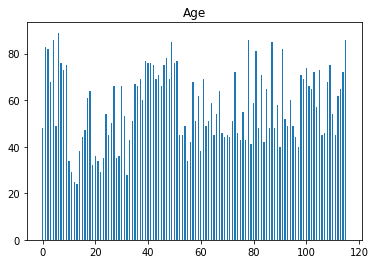

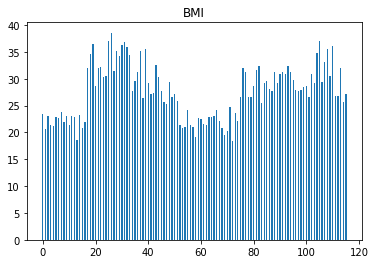

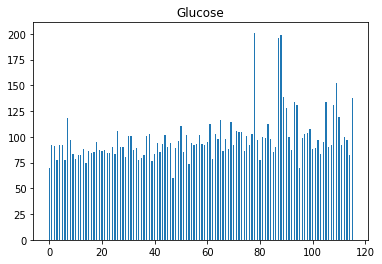

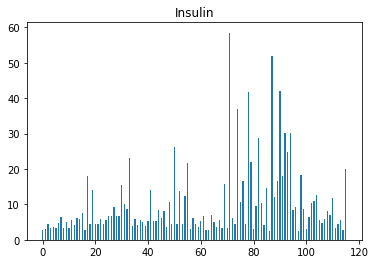

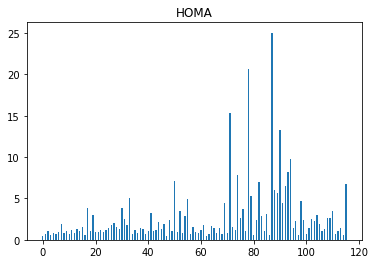

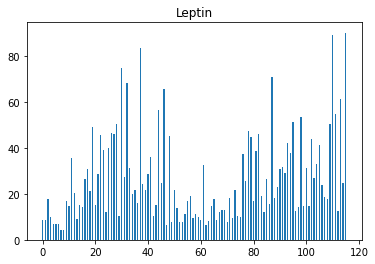

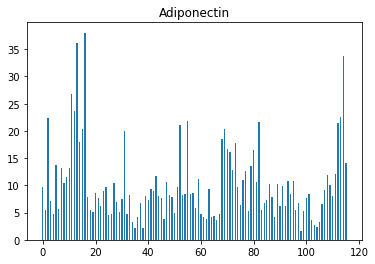

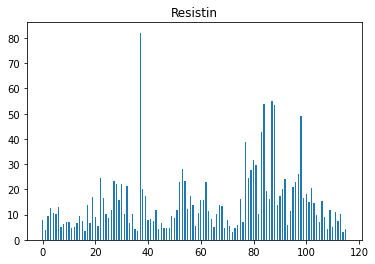

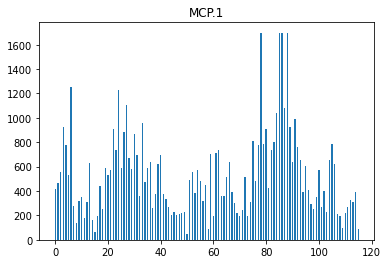

Without outliers the dimension of my database is  80  instead of  116
     Age        BMI  Glucose  ...  Resistin    MCP.1  Classification
0     48  23.500000       70  ...   7.99585  417.114               1
1     83  20.690495       92  ...   4.06405  468.786               1
3     68  21.367521       77  ...  12.76600  928.220               1
4     86  21.111111       92  ...  10.57635  773.920               1
5     49  22.854458       92  ...  10.31760  530.410               1
..   ...        ...      ...  ...       ...      ...             ...
103   72  29.136316       83  ...  14.76966  232.018               2
104   57  34.838148       95  ...   9.95420  655.834               2
106   45  29.384757       90  ...  15.55625  621.273               2
107   46  33.180000       92  ...   8.89000  209.190               2
111   45  26.850000       92  ...  10.96000  268.230               2

[80 rows x 10 columns]


In [0]:
# plot outliers
# for feature in X.columns: 
#   plt.bar(np.arange(X.shape[0]), X[feature], 0.5)
#   plt.title(feature)
#   plt.show()

cleanDs = data
# remove outliers
for feature in X.columns:
  df = X[feature]
  sorted(df)
  q1, q3= np.percentile(df,[25,75])
  iqr = q3-q1
  lower_bound = q1 -(1.5 * iqr) 
  upper_bound = q3 +(1.5 * iqr)
  cleanDs = cleanDs[(cleanDs[feature]>lower_bound) & (cleanDs[feature]<upper_bound)]


print("Without outliers the dimension of my database is ", cleanDs.shape[0], " instead of ", X.shape[0])

# temporary line
cleanDs.reset_index(drop=True)

<p> Check and balance Data </p>

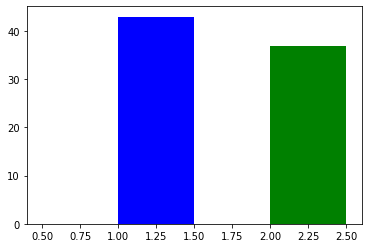

Percentage of 1 and 2 are:  53.75 % and  0.4625 %


In [0]:
Y = cleanDs.iloc[:, 9]
ones = Y[Y == 1]
twos = Y[Y == 2]
plt.hist(ones, color='blue', width=0.5)
plt.hist(twos, color='green', width=0.5)
plt.show()
print("Percentage of 1 and 2 are: ", ones.shape[0]/Y.shape[0]*100, "% and ", twos.shape[0]/Y.shape[0],"%")

<p>Observing the percentage of the two classes we can identify this dataset as balanced since the two classes don't go over the 60/40 ratio so it's acceptable.</p>

<p><p>Preprocessing<p></p>

In [0]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(cleanDs, Y, random_state=np.random.randint(0,100), test_size=0.27)

# array of possible K to apply KNN neighbors
ks = [3,5,7,9]

# normalize data because algorithms work better with normalized data
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

<p><u>K-NN</u></p>

In [0]:
for k in ks:
    n_neighbors = k
    
    # Create an instance of neighbors classifier (clf) and fit the data
    clf = neighbors.KNeighborsClassifier(n_neighbors)
    
    # train the classifier on the training set
    clf.fit(X_train, Y_train)
    
    print("Accuracy score on the test set with K =",n_neighbors,"is %.3f" %(clf.score(X_test, Y_test)))


    

Accuracy score on the test set with K = 3 is 0.636
Accuracy score on the test set with K = 5 is 0.636
Accuracy score on the test set with K = 7 is 0.773
Accuracy score on the test set with K = 9 is 0.682


<p><u>Logistic Regression</u><p>

In [0]:
logReg = LogisticRegression(solver="lbfgs", max_iter=2000) # instance of the model

logReg.fit(X_train, Y_train)

# res = logReg.predict(X_test)

print("Accuracy: ", logReg.score(X_test, Y_test))
print(classification_report(Y_test, logReg.predict(X_test)))

Accuracy:  0.5454545454545454
              precision    recall  f1-score   support

           1       0.70      0.50      0.58        14
           2       0.42      0.62      0.50         8

    accuracy                           0.55        22
   macro avg       0.56      0.56      0.54        22
weighted avg       0.60      0.55      0.55        22



<p><u> Random forest</u> </p>

In [0]:
rndFor = RandomForestClassifier(n_estimators = 100, criterion="entropy")

rndFor.fit(X_train, Y_train)

y_pred = rndFor.predict(X_test)

print("Accuracy: ", metrics.accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, rndFor.predict(X_test)))

Accuracy:  0.5909090909090909
              precision    recall  f1-score   support

           1       0.78      0.50      0.61        14
           2       0.46      0.75      0.57         8

    accuracy                           0.59        22
   macro avg       0.62      0.62      0.59        22
weighted avg       0.66      0.59      0.60        22



<p><u> SVM</u> </p>

In [0]:
svc = SVC(gamma='auto', kernel='rbf')
svc.fit(X_train, Y_train)
print("Accuracy: ", svc.score(X_test, Y_test))

Accuracy:  0.6818181818181818


<p> So this is the accuracy with the default parameters, but with SVm approach is necessary to perform some parameters tuning in order to achieve a better result. To do so I relied on the GridSearch <p>
<p><u> SVM with GridSearch </u></p>

In [0]:
parameters = [{'C': [0.1, 0.2, 1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [0.1, 0.2, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 0.25, 1], 'kernel': ['rbf']}]
svcGS = GridSearchCV(svc, parameters, n_jobs=-1, cv=5, refit=True)
svcGS.fit(X_train, Y_train)
# print("Accuracy: ", svcGS.score(X_test, Y_test))
print(classification_report(Y_test, svcGS.predict(X_test)),"\n")
cm = metrics.confusion_matrix(Y_test, svcGS.predict(X_test))

print ("Confusion Matrix:\n",cm)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, svcGS.predict(X_test), pos_label=2)
print("Area Under the ROC curve: ",metrics.auc(fpr, tpr))                                         

              precision    recall  f1-score   support

           1       0.75      0.86      0.80        14
           2       0.67      0.50      0.57         8

    accuracy                           0.73        22
   macro avg       0.71      0.68      0.69        22
weighted avg       0.72      0.73      0.72        22
 

Confusion Matrix:
 [[12  2]
 [ 4  4]]
Area Under the ROC curve:  0.6785714285714286


<p> The result above shows us a fuller report. </p>